In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import keras as keras

import datetime

%load_ext tensorboard

2025-11-28 16:59:41.835422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-28 16:59:41.835495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-28 16:59:41.918133: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-28 16:59:42.085993: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/xy/Desktop/ml/TF/legacy/lib/python3.10/site-pac

In [2]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2

In [3]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

2025-11-28 16:59:44.642105: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-28 16:59:44.678794: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-28 16:59:44.680640: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

61306/61306 [==============================] - 0s 1us/step


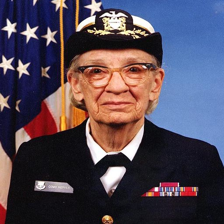

In [4]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [5]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [6]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

2025-11-28 17:00:18.913667: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


1/1 [==============================] - 1s 1s/step


(1, 1001)

In [7]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 0us/step


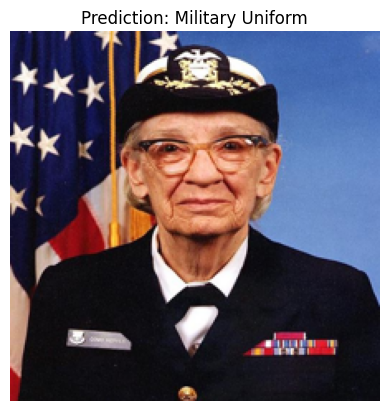

In [9]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [10]:
import pathlib

data_file = tf.keras.utils.get_file(
  'flower_photos.tgz',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
  cache_dir='.',
   extract=True)

data_root = pathlib.Path(data_file).with_suffix('')

228813984/228813984 [==============================] - 6s 0us/step


In [11]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [13]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


2025-11-28 17:01:57.815118: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [16]:
result_batch = classifier.predict(train_ds)

92/92 [==============================] - 3s 20ms/step


In [18]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'coral fungus', 'rapeseed', ..., 'daisy', 'daisy',
       'birdhouse'], dtype='<U30')

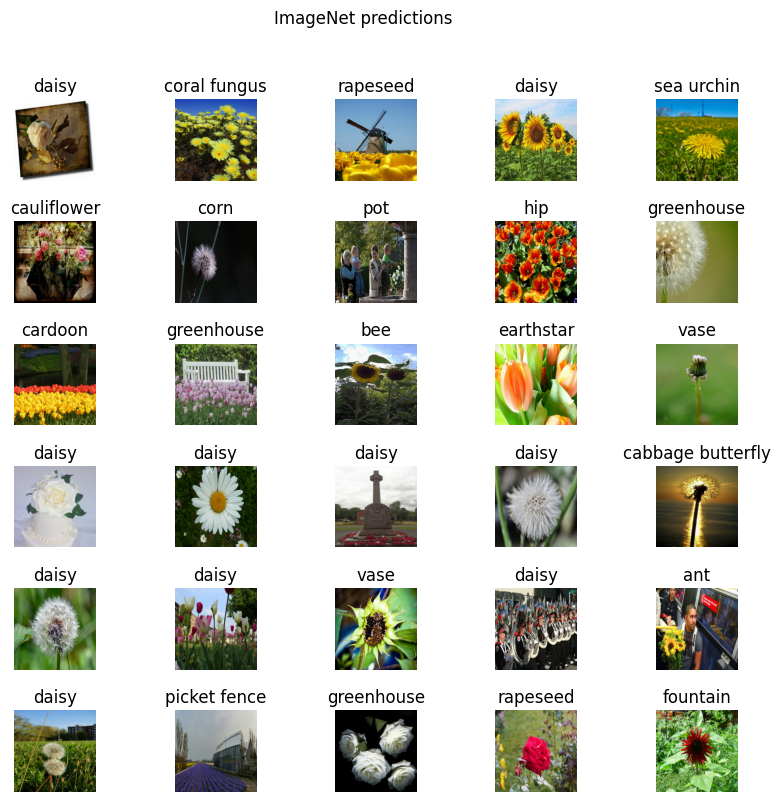

In [19]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [20]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [21]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [22]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [23]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [24]:
predictions = model(image_batch)

In [25]:
predictions.shape

TensorShape([32, 5])

In [26]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [27]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10


2025-11-28 17:03:50.382247: I external/local_xla/xla/service/service.cc:168] XLA service 0x74e872901540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-28 17:03:50.382266: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-11-28 17:03:50.399010: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764345830.479017   21464 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 [==============================] - 6s 42ms/step - loss: 0.7729 - acc: 0.7234 - val_loss: 0.4339 - val_acc: 0.8556
Epoch 2/10
92/92 [==============================] - 3s 32ms/step - loss: 0.3710 - acc: 0.8804 - val_loss: 0.3501 - val_acc: 0.8828
Epoch 3/10
92/92 [==============================] - 3s 32ms/step - loss: 0.2908 - acc: 0.9097 - val_loss: 0.3200 - val_acc: 0.8924
Epoch 4/10
92/92 [==============================] - 3s 33ms/step - loss: 0.2427 - acc: 0.9261 - val_loss: 0.3057 - val_acc: 0.8924
Epoch 5/10
92/92 [==============================] - 3s 34ms/step - loss: 0.2084 - acc: 0.9387 - val_loss: 0.2977 - val_acc: 0.8951
Epoch 6/10
92/92 [==============================] - 3s 35ms/step - loss: 0.1819 - acc: 0.9496 - val_loss: 0.2926 - val_acc: 0.8992
Epoch 7/10
92/92 [==============================] - 3s 36ms/step - loss: 0.1607 - acc: 0.9595 - val_loss: 0.2892 - val_acc: 0.8992
Epoch 8/10
92/92 [==============================] - 3s 36ms/step - loss: 0.1431 - acc: 0.9639 

In [28]:
%tensorboard --logdir logs/fit

In [29]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 0s 228ms/step
['roses' 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'roses' 'dandelion'
 'roses' 'tulips' 'dandelion' 'tulips' 'tulips' 'sunflowers' 'tulips'
 'dandelion' 'roses' 'daisy' 'tulips' 'dandelion' 'dandelion' 'dandelion'
 'tulips' 'sunflowers' 'roses' 'sunflowers' 'dandelion' 'tulips' 'roses'
 'roses' 'sunflowers' 'tulips' 'sunflowers']


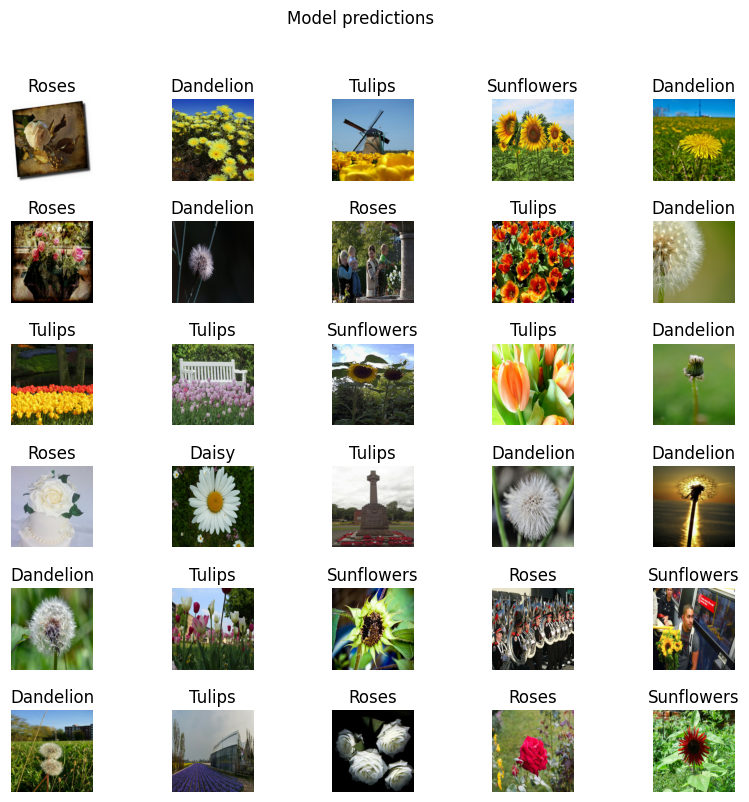

In [30]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [31]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1764345866/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1764345866/assets


'/tmp/saved_models/1764345866'

In [32]:
reloaded = tf.keras.models.load_model(export_path)

In [33]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 0s 244ms/step


In [34]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [35]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['roses' 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'roses' 'dandelion'
 'roses' 'tulips' 'dandelion' 'tulips' 'tulips' 'sunflowers' 'tulips'
 'dandelion' 'roses' 'daisy' 'tulips' 'dandelion' 'dandelion' 'dandelion'
 'tulips' 'sunflowers' 'roses' 'sunflowers' 'dandelion' 'tulips' 'roses'
 'roses' 'sunflowers' 'tulips' 'sunflowers']


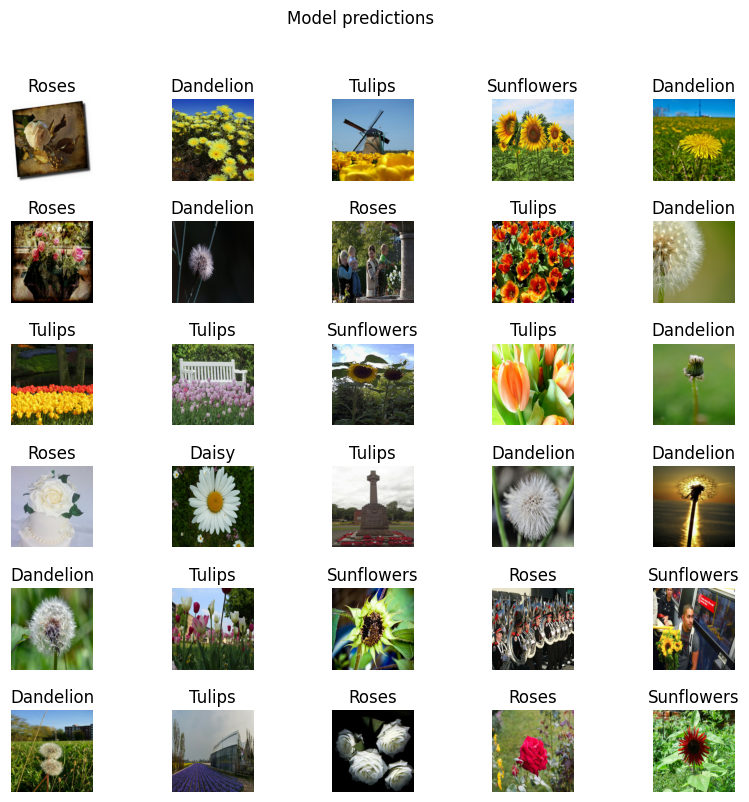

In [36]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")